In [27]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import pickle
import tensorflow as tf
import pickle


(X_train_org, Y_train), (X_test_org, Y_test) = tf.keras.datasets.mnist.load_data()
X_train = (X_train_org.reshape(X_train_org.shape[0],784)).T
X_test = (X_test_org.reshape(X_test_org.shape[0],784)).T




In [28]:
class Clock:
    def __init__(self):
        self.cycle = 0

    def tick(self):
        self.cycle += 1

    def reset(self):
        self.cycle = 0

In [29]:
class Mac:
    def __init__(self, x, y):
        self.x_cord = x
        self.y_cord = y
        self.acc = 0
        self.inpVer = 0
        self.inpHor = 0
        self.outVer = 0
        self.outHor = 0
        self.active = False
        self.log = [] 

    def read(self):
        self.outVer = self.inpVer
        self.outHor = self.inpHor

    def compute(self, clock):
        self.acc += self.inpHor * self.inpVer
        self.log.append((clock.cycle, self.acc))

    def reset(self):
        self.acc = 0
        self.inpHor = 0
        self.inpVer = 0
        self.outHor = 0
        self.outVer = 0
        self.active = True
        #self.log = []

    def print_log(self):
        for cycle, val in self.log:
            print(f"Cycle {cycle} | MAC[{self.x_cord}][{self.y_cord}] Acc = {val}")

In [30]:


class MacArray:
    def __init__(self, row, col):
        self.row = row
        self.col = col
        self.n = 0
        self.p = 0
        self.array = [[Mac(i, j) for j in range(col)] for i in range(row)]

    def reset(self):
        for row in self.array:
            for mac in row:
                mac.reset()

    def printMac(self):
        for row in self.array:
            for mac in row:
                mac.print_log()

    def get_result(self, p, n):
        return [
            [self.array[i][j].acc if getattr(self.array[i][j], "active", False) else 0
             for j in range(p)]
            for i in range(n)
        ]

    def multiply(self, A, B, clock, showprogress=False, returnResult=True):
        n, m, p = len(A), len(A[0]), len(B[0])
        if m != len(B):
            raise ValueError(f"Matrix dimensions do not match: {m} (A columns) != {len(B)} (B rows)")

        self.n = n
        self.p = p

        self.reset()
        clock.reset()

        total_cycles = n + m + p

        a_buffer = [[0 for _ in range(total_cycles)] for _ in range(n)]
        b_buffer = [[0 for _ in range(total_cycles)] for _ in range(p)]

        for i in range(n):
            for k in range(m):
                a_buffer[i][k + i] = A[i][k]

        for j in range(p):
            for k in range(m):
                b_buffer[j][k + j] = B[k][j]

        for t in range(total_cycles):
            for i in range(n):
                for j in range(p):
                    mac = self.array[i][j]
                    mac.active = True
                    mac.inpHor = a_buffer[i][t - j] if (t - j) >= 0 else 0
                    mac.inpVer = b_buffer[j][t - i] if (t - i) >= 0 else 0

            for i in range(n):
                for j in range(p):
                    self.array[i][j].read()
            for i in range(n):
                for j in range(p):
                    self.array[i][j].compute(clock)

            for i in range(n):
                for j in range(p):
                    mac = self.array[i][j]
                    if j + 1 < p:
                        self.array[i][j + 1].inpHor = mac.outHor
                    if i + 1 < n:
                        self.array[i + 1][j].inpVer = mac.outVer

            if showprogress:
                print(clock.cycle)
            clock.tick()

        if returnResult:
            return np.array(self.get_result(p, n)) 
        
def to_csv(self, filepath):
    with open(filepath, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["X", "Y", "Cycle", "Accumulator"])
        for cycle, val in self.log:
            writer.writerow([self.x_cord, self.y_cord, cycle, val])



In [31]:
#No propblem

X_train = X_train / 255.
X_test = X_test / 255.


In [32]:
X_train.shape

(784, 60000)

In [33]:
## MAking MAc array here

ma = MacArray(1000,1000)
clock =Clock()


In [34]:
def init_params():
    W1 = np.random.rand(128, 784) - 0.5
    b1 = np.random.rand(128, 1) - 0.5
    W2 = np.random.rand(64, 128) - 0.5
    b2 = np.random.rand(64, 1) - 0.5
    W3 = np.random.rand(10, 64) - 0.5
    b3 = np.random.rand(10, 1) - 0.5

    
    return W1, b1, W2, b2, W3, b3

#fine (above)

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True)) 
    return expZ / np.sum(expZ, axis=0, keepdims=True) #ok

def ReLU_deriv(Z):
    return (Z > 0).astype(int) #ok

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y #ok

def forward_prop(X, W1, b1, W2, b2, W3, b3):
    Z1 =   ma.multiply(W1,X,clock)+ b1
    A1 = ReLU(Z1)
    Z2 = ma.multiply(W2,A1,clock) + b2
    A2 = ReLU(Z2)
    Z3 = ma.multiply(W3,A2,clock) + b3 
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3 #ok

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    m = X.shape[1] 
    one_hot_Y = one_hot(Y)
    
   
    dZ3 = A3 - one_hot_Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)  


    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)  

    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)  
    
    return dW1, db1, dW2, db2, dW3, db3


def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3 
    b3 = b3 - alpha * db3
       
    return W1, b1, W2, b2, W3, b3 


In [35]:
def get_predictions(A3):
    return np.argmax(A3, 0)

def get_accuracy(predictions, Y):
    
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 ,W3, b3 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 ,Z3 ,A3 = forward_prop(X, W1, b1, W2, b2, W3, b3)
        dW1, db1, dW2, db2, dW3, db3= backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y)
        W1, b1, W2, b2 ,W3 ,b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        if i % 3 == 0:
            print(" on it sir Iteration: ", i)
            predictions = get_predictions(A3)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2 ,W3 ,b3

In [36]:
X_train[0].size

60000

In [37]:


def gd2(X_full, Y_full, alpha, iterations, W1, b1, W2, b2, W3, b3, bs=25, st=1):
    m = X_full[0].size
    epoch = m / 25

    for i in range(iterations):
        X = X_full[:, :((st + i) * bs) % m]
        Y = Y_full[:((st + i) * bs) % m]

        Z1, A1, Z2, A2, Z3, A3 = forward_prop(X, W1, b1, W2, b2, W3, b3)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3,
                                                     W1, W2, W3, X, Y)
        W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3,
                                               dW1, db1, dW2, db2, dW3, db3, alpha)

        if i % 3 == 0:
            print("on it sir Iteration:", i)
            predictions = get_predictions(A3)
            print(get_accuracy(predictions, Y))

        if i % epoch == 0:
            print("epoch:", i / epoch)

      
        if i % 10 == 0:
            weights = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
            with open(f"weightsSys.pkl", "wb") as f:
                pickle.dump(weights, f)

    return W1, b1, W2, b2, W3, b3


In [38]:
X_train[:][:10].shape

(10, 60000)

In [39]:
X_train.shape

(784, 60000)

In [40]:
Y_train.shape

(60000,)

In [41]:
one_hot(Y_train[:25]).shape

(10, 25)

In [42]:

#TO load pretrained weights
c = input("Do you want to import weights(Y/N)v:")
if c=='Y' or c=='y':
    

    with open("weightsSys.pkl", "rb") as f:
        weights = pickle.load(f)

    W1 = weights["W1"]
    b1 = weights["b1"]
    W2 = weights["W2"]
    b2 = weights["b2"]
    W3 = weights["W3"]
    b3 = weights["b3"]
    print("loaded")

loaded


In [43]:
W1, b1, W2, b2  ,W3 ,b3 = gradient_descent(X_train[:,:25], Y_train[:25].T, 0.225, 2)

 on it sir Iteration:  0
0.04


In [ ]:
W1, b1, W2, b2  ,W3 ,b3 = gd2(X_train, Y_train, 0.225, 10,W1, b1, W2, b2 ,W3, b3,bs = 25, st = 1)

In [50]:
def make_predictions(X, W1, b1, W2, b2, W3, b3):
 
    
    _, _, _, _, _, A3 = forward_prop(X, W1, b1, W2, b2, W3, b3)  
    predictions = get_predictions(A3)  
    return predictions

def test_prediction(index, X_test, Y_test, W1, b1, W2, b2, W3, b3):
   

    current_image = X_test[:, index, None]  
    
   
    prediction = make_predictions(current_image, W1, b1, W2, b2, W3, b3)
    label = Y_test[index]
    
   
    print("Prediction:", prediction[0]) 
    print("Label:", label)
    
    
    current_image = current_image.reshape((28, 28)) * 255  
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.title(f"Prediction: {prediction[0]}, Label: {label}")
    plt.show()

    
    

    
    

593
Prediction: 5
Label: 9


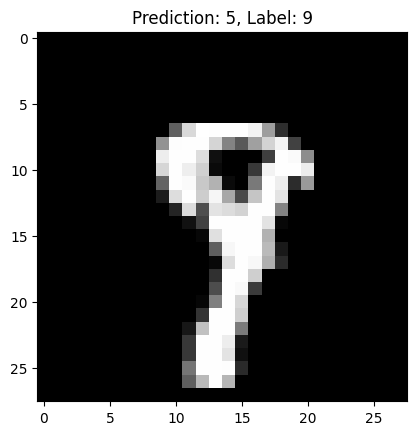

In [51]:
k=random.randint(0, 1000)
print(k)
test_prediction(k, X_test, Y_test, W1, b1, W2, b2, W3 , b3)


#645




In [52]:
def final_test(X_test, Y_test, W1, b1, W2, b2, W3, b3, iterations):
    total_samples = min(iterations, X_test.shape[1]) 
    correct_predictions = 0
    error_List = []

    for i in range(total_samples):
        if i % 10 == 0:  
            print("Processing Iteration:", i)

       
        current_image = X_test[:, i, None] 
        
        
        prediction = make_predictions(current_image, W1, b1, W2, b2, W3, b3)
        
       
        if prediction == Y_test[i]:
            correct_predictions += 1
        else:
            error_List.append(i)
    
    

    print("Total error : ")
    print(len(error_List))
    accuracy = correct_predictions / total_samples * 100
    print(f"Final Accuracy over {total_samples} samples: {accuracy:.4f}%")
    return accuracy,error_List


In [53]:
X_train.shape


(784, 60000)

In [ ]:
ma.printMac()

In [ ]:
final_test(X_test, Y_test, W1, b1, W2, b2, W3, b3, 60)